In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame = pd.read_csv('./mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


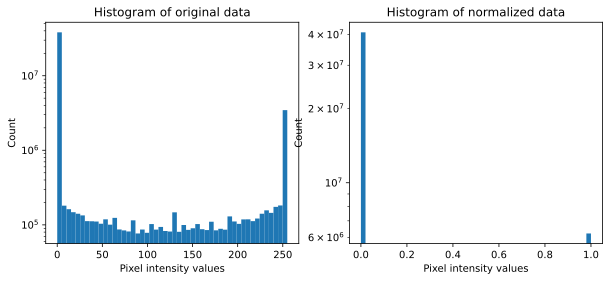

In [3]:
# normalize data to a range of [0, 1]
data_norm = data / np.max(data)

data_norm[data_norm>=.5] = 1
data_norm[data_norm<.5] = 0

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [4]:
data_invert = ~data_norm.astype('bool')

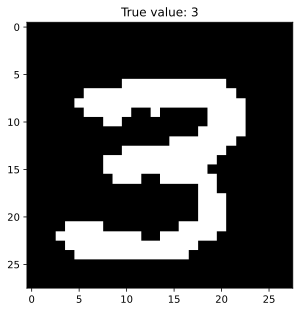

In [5]:
num = 111

plt.imshow(np.reshape(data_norm[num, :], (28, 28)), cmap='gray')
plt.title(f"True value: {labels[num]}")
plt.show()

In [6]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [7]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x), axis=1)
        
    model = MnistNet()
    
    loss_fun = nn.NLLLoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [8]:
model, loss_fun, optimizer = create_model()

X, y = next(iter(train_loader))
yHat = model(X)

print(yHat)
loss = loss_fun(yHat, y)
print(' ')
print('Loss:')
print(loss)

tensor([[-2.3368, -2.2893, -2.4129, -2.2897, -2.2156, -2.1690, -2.3690, -2.2620,
         -2.2264, -2.4991],
        [-2.3558, -2.2775, -2.4024, -2.2905, -2.2307, -2.1620, -2.3678, -2.2729,
         -2.2130, -2.4975],
        [-2.3294, -2.2783, -2.4162, -2.2831, -2.2463, -2.1702, -2.3609, -2.2737,
         -2.2117, -2.4983],
        [-2.3597, -2.2647, -2.4073, -2.2693, -2.2393, -2.1750, -2.3706, -2.2621,
         -2.2214, -2.5000],
        [-2.3468, -2.2884, -2.4054, -2.2903, -2.2048, -2.1715, -2.3679, -2.2707,
         -2.2243, -2.4998],
        [-2.3507, -2.2842, -2.4124, -2.2799, -2.2243, -2.1752, -2.3557, -2.2639,
         -2.2182, -2.5053],
        [-2.3308, -2.2895, -2.4104, -2.2950, -2.2241, -2.1682, -2.3600, -2.2683,
         -2.2217, -2.5004],
        [-2.3346, -2.2839, -2.4208, -2.2791, -2.2314, -2.1639, -2.3624, -2.2638,
         -2.2244, -2.5072],
        [-2.3421, -2.2801, -2.4158, -2.2759, -2.2469, -2.1667, -2.3687, -2.2717,
         -2.2037, -2.4988],
        [-2.3328, -

In [9]:
num_of_epochs = 60
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        X,y = next(iter(test_loader))
        yHat = model(X)
        
        test_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, test_acc, losses, model

In [10]:
train_acc, test_acc, losses, model = train_model()

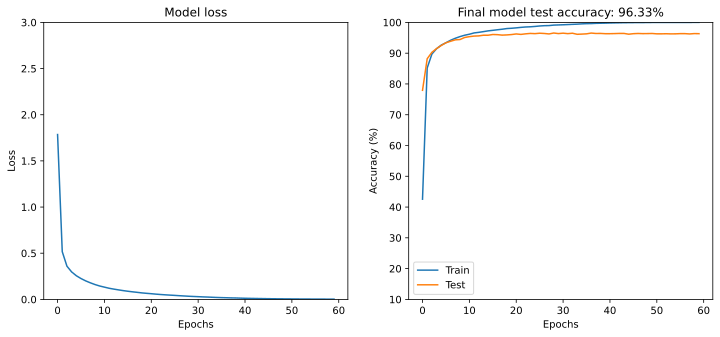

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()